In [21]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import numpy as np
import itertools
from tqdm import trange
import scipy.sparse
import numpy.testing as npt
from integration_helpers import normalize_by_gene_length, sanitize_adata, validate_adata, add_doublet_annotation, undo_log_norm
from threadpoolctl import threadpool_limits
from tqdm.contrib.concurrent import process_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
threadpool_limits(8)

In [19]:
sc.set_figure_params(figsize=(5, 5))

In [2]:
annotated_datasets = {
    "Maynard_Bivona_2020_NSCLC": sc.read_h5ad("../../data/30_annotate_scrnaseq_data/maynard_annotated.h5ad"),
    "Lambrechts_2018_LUAD_6653" : sc.read_h5ad("../../data/30_annotate_scrnaseq_data/lambrechts_annotated.h5ad")
}

In [3]:
datasets = {
    "Maynard_Bivona_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Maynard_Bivona_2020_NSCLC/Maynard_Bivona_2020_NSCLC.qc.h5ad"),
    "Lambrechts_2018_LUAD_6653": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Lambrechts_2018_LUAD_6653/Lambrechts_2018_LUAD_6653.qc.h5ad"),
    "Adams_Kaminski_2020_COPD": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Adams_Kaminski_2020_COPD/Adams_Kaminski_2020_COPD.qc.h5ad"),
    "Goveia_Carmeliet_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Goveia_Carmeliet_2020_NSCLC/Goveia_Carmeliet_2020_NSCLC.qc.h5ad"),
    "Guo_Zhang_2018_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Guo_Zhang_2018_NSCLC/Guo_Zhang_2018_NSCLC.qc.h5ad"),
    "Lambrechts_2018_LUAD_6149": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Lambrechts_2018_LUAD_6149/Lambrechts_2018_LUAD_6149.qc.h5ad"),
    "Laughney_Massague_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Laughney_Massague_2020_NSCLC/Laughney_Massague_2020_NSCLC.qc.h5ad"),
    "Lukassen_Eils_2020_LUAD": sc.read_h5ad("../../data/10_public_datasets/Lukassen_Eils_2020_LUAD/h5ad_processed/lukassen20_lung_orig.processed.h5ad"),
    "Madissoon_Meyer_2020_pulmonary-fibrosis" : sc.read_h5ad("../../data/10_public_datasets/Madissoon_Meyer_2020_pulmonary-fibrosis/h5ad_processed/madissoon19_lung.processed.h5ad"),
    "Maier_Merad_2020_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Maier_Merad_2020_NSCLC/Maier_Merad_2020_NSCLC.qc.h5ad"),
    "Mayr_Schiller_2020_pulmonary-fibrosis": sc.read_h5ad("../../data/10_public_datasets/Mayr_Schiller_2020_pulmonary-fibrosis/h5ad/integrated_human_dataset.h5ad"),
    "Pircher_batch1_NSCLC": sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/batch1_3patients/batch1_3patients.qc.h5ad")
}

/home/sturm/.conda/envs/scanpy_2020-12/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/sturm/.conda/envs/scanpy_2020-12/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [4]:
doublet_files = {
    "Adams_Kaminski_2020_COPD": "../../data/20_qc_norm_scrnaseq/02_solo/Adams_Kaminski_2020_COPD/Adams_Kaminski_2020_COPD.is_doublet.csv",
    "Goveia_Carmeliet_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Goveia_Carmeliet_2020_NSCLC/Goveia_Carmeliet_2020_NSCLC.is_doublet.csv",
    "Guo_Zhang_2018_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Guo_Zhang_2018_NSCLC/Guo_Zhang_2018_NSCLC.is_doublet.csv",
    "Lambrechts_2018_LUAD_6149": "../../data/20_qc_norm_scrnaseq/02_solo/Lambrechts_2018_LUAD_6149/Lambrechts_2018_LUAD_6149.is_doublet.csv",
    "Laughney_Massague_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Laughney_Massague_2020_NSCLC/Laughney_Massague_2020_NSCLC.is_doublet.csv",
    "Maier_Merad_2020_NSCLC": "../../data/20_qc_norm_scrnaseq/02_solo/Maier_Merad_2020_NSCLC/Maier_Merad_2020_NSCLC.is_doublet.csv",
    "Mayr_Schiller_2020_pulmonary-fibrosis": "../../data/10_public_datasets/Mayr_Schiller_2020_pulmonary-fibrosis/h5ad/integrated_human_dataset.h5ad",
    "Pircher_batch1_NSCLC":"../../data/20_qc_norm_scrnaseq/02_solo/batch1_3patients/batch1_3patients.is_doublet.csv"
}

### Add doublet information and filter datasets

... storing 'is_doublet' as categorical


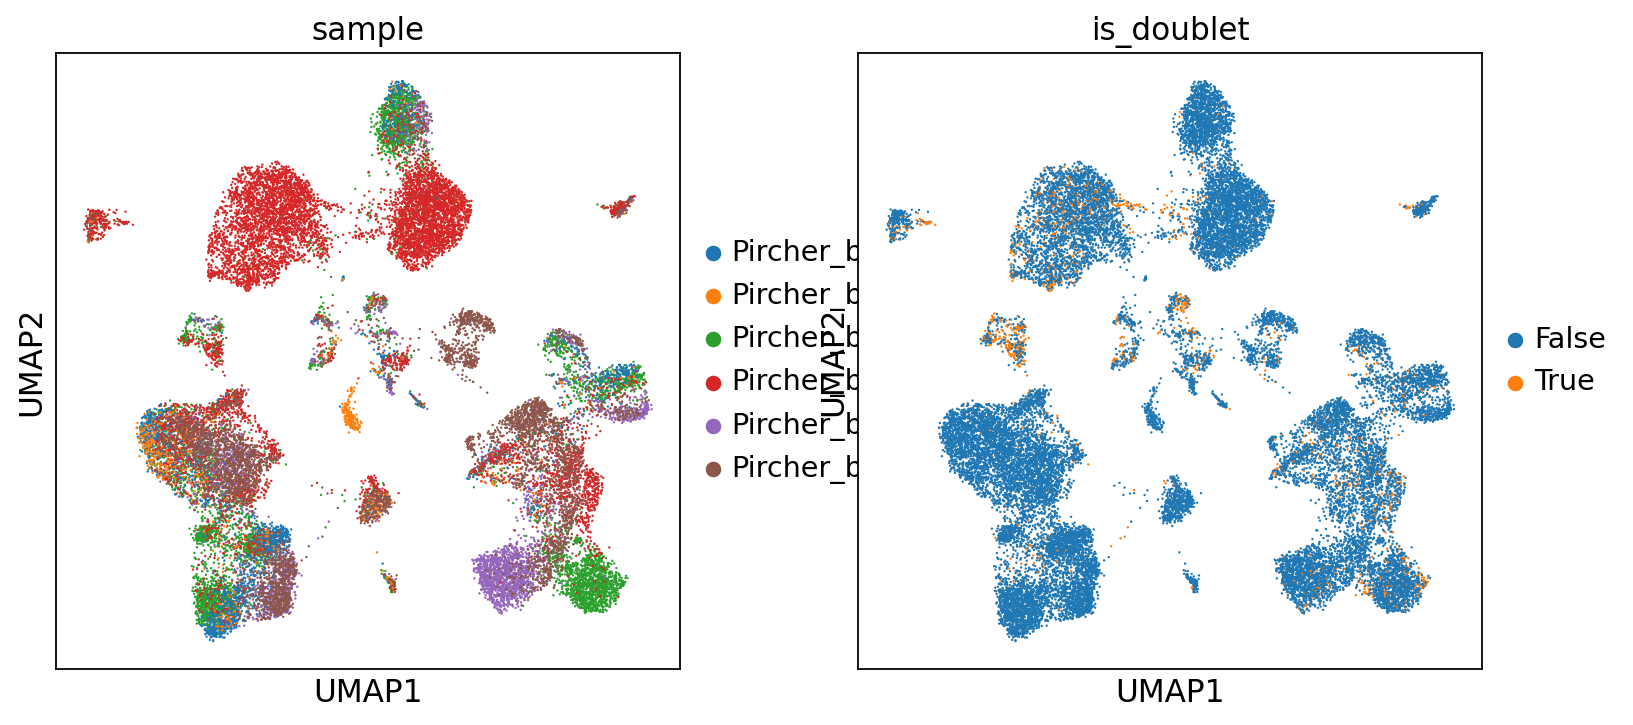

AnnData object with n_obs × n_vars = 26145 × 26636
    obs: 'patient', 'tissue', 'tumor_id', 'age', 'sex', 'tumor_type', 'condition', 'origin', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'dataset', 'is_doublet'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'is_doublet_colors'
    obsm: 'surface_protein', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [20]:
datasets_vis = process_map(add_doublet_annotation, [datasets[k] for k in doublet_files], doublet_files.values())

In [16]:
for dataset_id, doublet_file in doublet_files.items():
    add_doublet_annotation(datasets[dataset_id], doublet_file)

KeyboardInterrupt: 

### Dataset-specific filtering and metadata fixes

In [5]:
datasets["Maynard_Bivona_2020_NSCLC"] = normalize_by_gene_length(datasets["Maynard_Bivona_2020_NSCLC"])

In [6]:
datasets["Adams_Kaminski_2020_COPD"].obs["origin"] = "normal"
datasets["Adams_Kaminski_2020_COPD"].obs["sex"] = "nan"
datasets["Adams_Kaminski_2020_COPD"] = datasets["Adams_Kaminski_2020_COPD"][datasets["Adams_Kaminski_2020_COPD"].obs["condition"] != "IPF", :]

In [7]:
datasets["Goveia_Carmeliet_2020_NSCLC"] = datasets["Goveia_Carmeliet_2020_NSCLC"][datasets["Goveia_Carmeliet_2020_NSCLC"].obs["condition"] != 'LLCC'].copy()
datasets["Goveia_Carmeliet_2020_NSCLC"].obs["sex"] = "nan"

In [8]:
datasets["Guo_Zhang_2018_NSCLC"] = datasets["Guo_Zhang_2018_NSCLC"][datasets["Guo_Zhang_2018_NSCLC"].obs["tissue"] != 'blood'].copy()
datasets["Guo_Zhang_2018_NSCLC"] = normalize_by_gene_length(datasets["Guo_Zhang_2018_NSCLC"])
datasets["Guo_Zhang_2018_NSCLC"].obs["sex"] = "nan"

In [9]:
datasets["Laughney_Massague_2020_NSCLC"].obs["sex"] = "nan"

In [10]:
undo_log_norm(datasets["Lukassen_Eils_2020_LUAD"])
datasets["Lukassen_Eils_2020_LUAD"].obs["sex"] = [{"M": "male", "F": "female"}[s] for s in datasets["Lukassen_Eils_2020_LUAD"].obs["sex"]]

In [11]:
tmp_obs = datasets["Lukassen_Eils_2020_LUAD"].obs
tmp_obs["patient"] = tmp_obs["orig.ident"]
tmp_obs["sample"] = tmp_obs["orig.ident"]
tmp_obs["tissue"] = "lung"
tmp_obs["origin"] = "normal"
tmp_obs["condition"] = "LUAD"

In [12]:
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["tissue"] = "lung"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["origin"] = "normal"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["condition"] = "healthy_control"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].obs["sex"] = "nan"
datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].X.data = np.rint(datasets["Madissoon_Meyer_2020_pulmonary-fibrosis"].X.data)

In [13]:
datasets["Maier_Merad_2020_NSCLC"].obs["sex"] = "nan"

In [14]:
tmp_obs = datasets["Mayr_Schiller_2020_pulmonary-fibrosis"].obs
tmp_obs["sex"] = [{"M": "male", "F": "female"}[s] for s in tmp_obs["Sex"]]
tmp_obs["condition"] = [{"control donor": "healthy_control", "endstage lung fibrosis": "pulmonary_fibrosis"}[d] for d in tmp_obs["health_status"]]
tmp_obs["patient"] = tmp_obs["patient_id"]
tmp_obs["sample"] = tmp_obs["patient_id"]
tmp_obs["tissue"] = "lung"
tmp_obs["origin"] = "normal"

datasets["Mayr_Schiller_2020_pulmonary-fibrosis"] = datasets["Mayr_Schiller_2020_pulmonary-fibrosis"][datasets["Mayr_Schiller_2020_pulmonary-fibrosis"].obs["condition"] != "pulmonary_fibrosis", :].copy()

### Validate data

In [15]:
for dataset_id, adata in datasets.items():
    print(f"Validating {dataset_id}")
    adata.obs["dataset"] = dataset_id
    sanitize_adata(adata)
    validate_adata(adata)

Validating Maynard_Bivona_2020_NSCLC


... storing 'sample' as categorical
... storing 'dataset' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical


Validating Lambrechts_2018_LUAD_6653


Trying to set attribute `.obs` of view, copying.


Validating Adams_Kaminski_2020_COPD


... storing 'sample' as categorical
... storing 'origin' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical


Validating Goveia_Carmeliet_2020_NSCLC


... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical


Validating Guo_Zhang_2018_NSCLC


... storing 'dataset' as categorical
... storing 'sample' as categorical


Validating Lambrechts_2018_LUAD_6149


... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical


Validating Laughney_Massague_2020_NSCLC


... storing 'sex' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'origin' as categorical
... storing 'condition' as categorical


Validating Lukassen_Eils_2020_LUAD


... storing 'dataset' as categorical


Validating Madissoon_Meyer_2020_pulmonary-fibrosis


... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'origin' as categorical
... storing 'condition' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'dataset' as categorical


Validating Maier_Merad_2020_NSCLC
Validating Mayr_Schiller_2020_pulmonary-fibrosis


... storing 'sex' as categorical
... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'origin' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'dataset' as categorical


Validating Pircher_batch1_NSCLC
